In [2]:
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None 

all_data = pd.read_csv('Data\submission_and_comments_V3.csv', sep = ";")
data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]

C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. PCA

In [11]:
def tfidf_clustering_dimreduc(algo):
    vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
    tf_idf = vectorizer.fit_transform(data['submission_title'])
    words = vectorizer.get_feature_names_out()
    tf_idf = csr_matrix(tf_idf)
    tf_idf = normalize(tf_idf)
    tf_idf.todense()
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(tf_idf.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    if algo == 'kmeans':
        clustering_model = KMeans(n_clusters=3, random_state=42)
        clustering_model.fit(tf_idf)
        clusters = clustering_model.labels_
    elif algo == "gm":
        clustering_model = GaussianMixture(n_components=3, random_state=0, covariance_type='diag')
        clustering_model.fit(tf_idf.toarray())
        clusters = clustering_model.predict(tf_idf.toarray())
        
    return x0, x1, clusters

C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


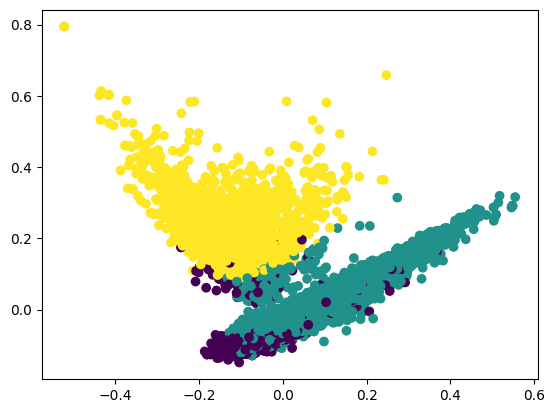

In [5]:
x0_kmeans, x1_kmeans, clusters_kmeans = tfidf_clustering_dimreduc(algo = "kmeans")
plt.scatter(x0_kmeans, x1_kmeans, c=clusters_kmeans)

# 2. Gaussian Mixtures

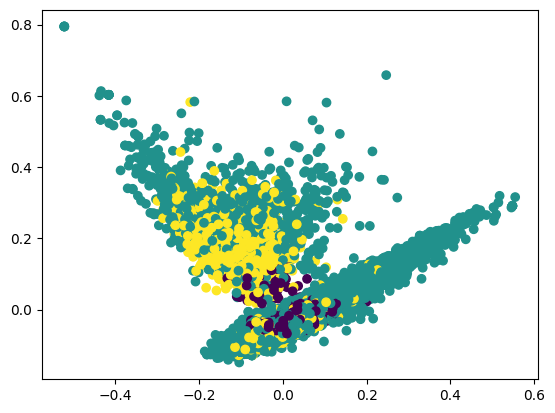

In [12]:
x0_gm, x1_gm, clusters_gm = tfidf_clustering_dimreduc(algo = "gm")
plt.scatter(x0_gm, x1_gm, c=clusters_gm)

# 3. Store Kmeans clusters for manual analysis

In [3]:
vectorizer = TfidfVectorizer(max_df=0.8)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(data['submission_title'])
words = vectorizer.get_feature_names_out()
tf_idf = csr_matrix(tf_idf)
tf_idf = normalize(tf_idf)
np.shape(tf_idf)

(20514, 10340)

In [4]:
submission_titles = data[['submission_title']]
submission_titles = submission_titles.reset_index()

k_range = range(10, 501, 50)
for k in tqdm.tqdm(k_range):
    clustering_model = KMeans(n_clusters=k, random_state=42, init = "k-means++", n_init = "auto")
    clustering_model.fit(tf_idf)
    submission_titles[f'KMeans_k={k}_AllDims'] = clustering_model.labels_

    top_words_list = []

    for k_see_words in np.unique(clustering_model.labels_):
        index_cluster = submission_titles[submission_titles[f'KMeans_k={k}_AllDims'] == k_see_words].index
        mean_idf = np.array(tf_idf[index_cluster].todense().mean(axis = 0))[0]
        top3_words_index = np.argsort(mean_idf)[-5:][::-1]
        top_words_list.append([words[ind] for ind in top3_words_index])

    cluster2top_words = dict(zip(np.unique(clustering_model.labels_), top_words_list))
    submission_titles[f'Top5_k={k}'] = submission_titles[f'KMeans_k={k}_AllDims'].apply(lambda x: cluster2top_words[x])

100%|██████████| 10/10 [01:16<00:00,  7.66s/it]


460


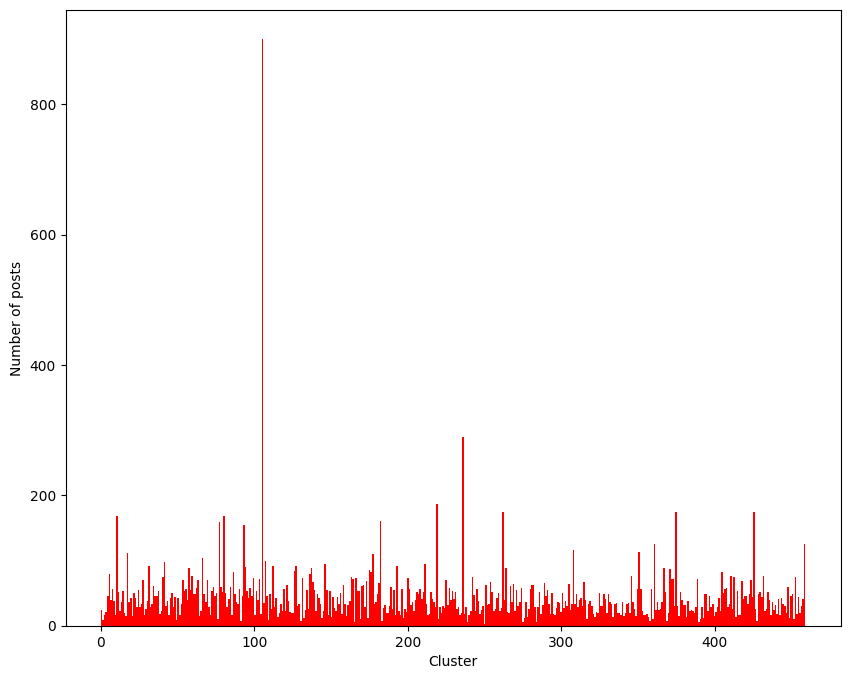

In [25]:
k_clusters = max(k_range)
print(k_clusters)

plt.figure(figsize = (10, 8))
submission_titles[f'KMeans_k={k_clusters}_AllDims'].hist(bins = k_clusters, color = 'r')
plt.xlabel('Cluster')
plt.ylabel('Number of posts')
plt.grid(None)
plt.show()

In [5]:
submission_titles

,index,submission_title,KMeans_k=10_AllDims,Top5_k=10,KMeans_k=60_AllDims,Top5_k=60,KMeans_k=110_AllDims,Top5_k=110,KMeans_k=160_AllDims,Top5_k=160,...,KMeans_k=260_AllDims,Top5_k=260,KMeans_k=310_AllDims,Top5_k=310,KMeans_k=360_AllDims,Top5_k=360,KMeans_k=410_AllDims,Top5_k=410,KMeans_k=460_AllDims,Top5_k=460
0,1,Another reason I need to get off social media-...,8,"[social, media, to, and, of]",58,"[off, get, my, phone, to]",58,"[off, get, my, phone, to]",74,"[people, are, who, they, to]",...,74,"[people, they, are, their, other]",74,"[people, they, are, their, other]",356,"[off, get, how, to, my]",325,"[people, who, are, media, social]",267,"[get, how, off, to, out]"
1,2,Having a flip phone changed my life (for good),1,"[phone, my, to, dumb, flip]",12,"[phone, dumb, my, flip, to]",12,"[phone, dumb, flip, my, to]",14,"[changed, life, has, my, how]",...,10,"[flip, phone, to, getting, the]",14,"[changed, life, has, my, how]",14,"[changed, life, my, has, how]",164,"[flip, phone, to, switched, getting]",164,"[flip, phone, to, switched, getting]"
2,4,The ultimate nosurf solution by using timer so...,3,"[for, my, and, the, reddit]",5,"[the, of, internet, to, and]",13,"[to, nosurf, and, my, youtube]",131,"[using, stop, to, the, internet]",...,193,"[nosurf, for, to, and, my]",38,"[and, to, my, the, for]",268,"[by, the, reddit, to, media]",326,"[solution, possible, for, the, to]",326,"[solution, possible, to, for, the]"
3,5,I'm thankful for ads,3,"[for, my, and, the, reddit]",13,"[to, nosurf, for, my, and]",78,"[for, looking, nosurf, the, to]",33,"[to, for, of, in, is]",...,33,"[my, for, is, reddit, of]",33,"[my, for, to, of, is]",33,"[my, to, of, in, for]",105,"[the, and, to, with, for]",105,"[and, to, with, on, from]"
4,6,"On Silence (and creativity), a short essay by ...",3,"[for, my, and, the, reddit]",13,"[to, nosurf, for, my, and]",13,"[to, nosurf, and, my, youtube]",3,"[handle, silence, how, sit, learning]",...,3,"[handle, silence, how, sit, to]",3,"[handle, silence, how, sit, to]",3,"[handle, silence, how, sit, learning]",105,"[the, and, to, with, for]",105,"[and, to, with, on, from]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20509,22138,Joining the no surf september challenge,3,"[for, my, and, the, reddit]",54,"[surf, no, for, to, day]",106,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, nosurf, no, 30]",...,83,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, no, nosurf, 30]",162,"[challenge, day, nosurf, 30, september]",457,"[challenge, day, 30, september, no]"
20510,22139,1st report for my September Challenge,3,"[for, my, and, the, reddit]",13,"[to, nosurf, for, my, and]",106,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, nosurf, no, 30]",...,83,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, no, nosurf, 30]",83,"[challenge, day, no, nosurf, 30]",162,"[challenge, day, nosurf, 30, september]",457,"[challenge, day, 30, september, no]"
20511,22140,Suggest software to make the nosurf experience...,0,"[to, how, addicted, the, reddit]",5,"[the, of, internet, to, and]",43,"[the, internet, is, to, of]",151,"[experience, my, with, nosurf, the]",...,59,"[make, to, it, change, you]",261,"[experience, my, nosurf, with, of]",261,"[experience, my, with, nosurf, and]",89,"[make, does, you, it, to]",89,"[make, does, change, you, to]"
20512,22141,No Surf September,3,"[for, my, and, the, reddit]",54,"[surf, no, for, to, day]",54,"[surf, no, for, day, to]",31,"[surf, no, for, to, day]",...,249,"[surf, no, for, to, day]",249,"[surf, no, for, day, to]",270,"[surf, no, to, day, you]",10,"[surf, no, for, day, to]",10,"[surf, no, for, day, to]"


In [12]:
submission_titles.to_csv('Kmeans_TitlesClusters_k=10to460.csv')
submission_titles

,submission_title,KMeans_k=10_AllDims,KMeans_k=60_AllDims,KMeans_k=110_AllDims,KMeans_k=160_AllDims,KMeans_k=210_AllDims,KMeans_k=260_AllDims,KMeans_k=310_AllDims,KMeans_k=360_AllDims,KMeans_k=410_AllDims,KMeans_k=460_AllDims
1,Another reason I need to get off social media-...,8,58,58,74,149,74,74,356,325,267
2,Having a flip phone changed my life (for good),1,12,12,14,14,10,14,14,164,164
4,The ultimate nosurf solution by using timer so...,3,5,13,131,193,193,38,268,326,326
5,I'm thankful for ads,3,13,78,33,33,33,33,33,105,105
6,"On Silence (and creativity), a short essay by ...",3,13,13,3,3,3,3,3,105,105
...,...,...,...,...,...,...,...,...,...,...,...
22138,Joining the no surf september challenge,3,54,106,83,83,83,83,83,162,457
22139,1st report for my September Challenge,3,13,106,83,83,83,83,83,162,457
22140,Suggest software to make the nosurf experience...,0,5,43,151,151,59,261,261,89,89
22141,No Surf September,3,54,54,31,31,249,249,270,10,10


In [15]:
def tf_idf_dim_reduction_clustering(algo, n_clusters = 2):
    vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
    tf_idf = vectorizer.fit_transform(data['submission_title'])
    words = vectorizer.get_feature_names_out()
    tf_idf = csr_matrix(tf_idf)
    tf_idf = normalize(tf_idf)
    tf_idf.todense()
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(tf_idf.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    if algo == 'kmeans':
        clustering_model = KMeans(n_clusters = n_clusters, random_state=42)
        clustering_model.fit(pca_vecs)
    elif algo == "gm":
        clustering_model = GaussianMixture(n_components = n_clusters, random_state=0)
        clustering_model.fit(pca_vecs)
        
    clusters = clustering_model.labels_
    return x0, x1, clusters


C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


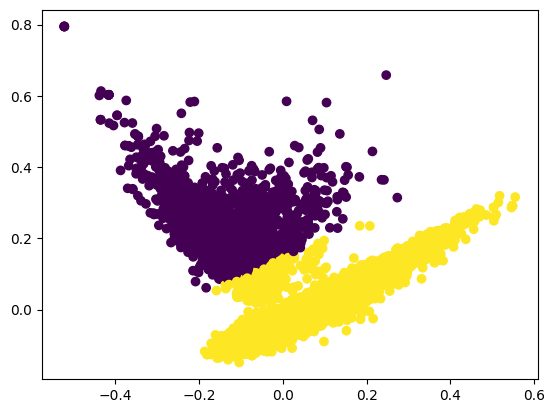

In [16]:
x0_kmeans, x1_kmeans, clusters_kmeans = tf_idf_dim_reduction_clustering(algo = "kmeans")
plt.scatter(x0_kmeans, x1_kmeans, c=clusters_kmeans)

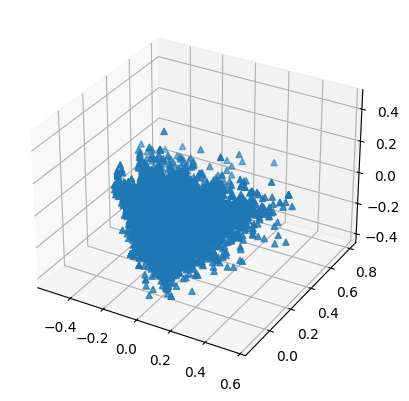

In [19]:
vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(data['submission_title'])
words = vectorizer.get_feature_names_out()
tf_idf = csr_matrix(tf_idf)
tf_idf = normalize(tf_idf)
tf_idf.todense()
pca = PCA(n_components=3, random_state=42)
pca_vecs = pca.fit_transform(tf_idf.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
x2 = pca_vecs[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x0, x1, x2, marker = "^")
plt.show()

## 2. UMAP

In [29]:
umap_reducer = umap.UMAP(metric = "euclidean", verbose = True, n_neighbors = 200, min_dist = 0)
umap_embedding = umap_reducer.fit_transform(tf_idf)

UMAP(min_dist=0, n_neighbors=200, verbose=True)
Sat May 20 19:48:12 2023 Construct fuzzy simplicial set
Sat May 20 19:48:12 2023 Finding Nearest Neighbors
Sat May 20 19:48:12 2023 Building RP forest with 12 trees
Sat May 20 19:48:14 2023 metric NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	 7  /  14
	Stopping threshold met -- exiting after 7 iterations
Sat May 20 20:16:23 2023 Finished Nearest Neighbor Search
Sat May 20 20:16:24 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:15]

Sat May 20 20:16:42 2023 Finished embedding


C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


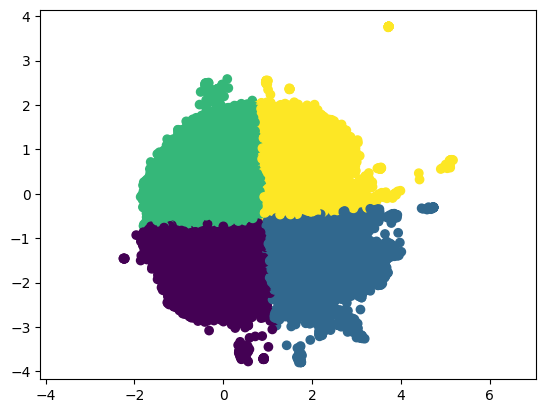

In [40]:
clustering_model = KMeans(n_clusters = 4, random_state=42)
clustering_model.fit(umap_embedding)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c = clustering_model.labels_)
plt.gca().set_aspect('equal', 'datalim')  #not good --> all points aggregated together apart from a few number of outliers